# 投球タイプ分類器（Pitch Identification Model）- XGBoost最終版
**作成日**: 2026/01/14  
**ベースライン (asao_1321, 同一CSV)**: Accuracy 90.4%  
**本モデル**: XGBoost単体で **Accuracy 95.2%** を達成

## 改善ポイント
1. **投手相対特徴量の追加**: `speed_diff`, `spin_diff`, `pfx_x_diff`, `pfx_z_diff`
2. **GridSearchによるパラメータ最適化**: XGBoost
3. **XGBoost単体がアンサンブルより高精度であることを確認**

## データ
- `train_pitcher_v2.csv`: 学習データ（約49.5万件）
- `test_pitcher_v2.csv`: テストデータ（約21.2万件）

## モデル選択の根拠
- XGBoost単体: **Accuracy 95.2%, FC Recall 88.3%**
- アンサンブル: Accuracy 94.0%, FC Recall 84.1%
- **XGBoost単体がアンサンブルを上回るため、XGBoostを最終モデルとして採用**

---


## 0. ライブラリ読み込み

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import warnings
warnings.filterwarnings('ignore')

# 機械学習モデル
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             f1_score, precision_recall_curve, roc_auc_score)
import xgboost as xgb
import lightgbm as lgb

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Some analysis will be skipped.")

# フォント設定
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'Hiragino Sans'
else:
    plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = [12, 8]

print("ライブラリ読み込み完了")


ライブラリ読み込み完了


## 1. データ読み込み・概観
CSVファイル（投手相対特徴量付き）を読み込みます。

In [2]:
# データ読み込み
train_data = pd.read_csv('train_pitcher_v2.csv')
test_data = pd.read_csv('test_pitcher_v2.csv')

print(f"学習データ: {train_data.shape[0]:,}件, {train_data.shape[1]}変数")
print(f"テストデータ: {test_data.shape[0]:,}件, {test_data.shape[1]}変数")

# 全データ
data = pd.concat([train_data, test_data], ignore_index=True)
print(f"\n総データ数: {data.shape[0]:,}件")


学習データ: 495,322件, 28変数
テストデータ: 212,282件, 28変数

総データ数: 707,604件


In [3]:
# データ概観
print("=== カラム一覧 ===")
for i, col in enumerate(data.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\n=== データ型 ===")
print(data.dtypes)


=== カラム一覧 ===
   1. release_speed
   2. release_spin_rate
   3. spin_axis
   4. pfx_x
   5. pfx_z
   6. release_pos_x
   7. release_pos_z
   8. p_throws
   9. normalized_spin_axis
  10. movement_angle
  11. abs_horizontal_movement
  12. movement_magnitude
  13. spin_efficiency
  14. speed_spin_ratio
  15. horizontal_vertical_ratio
  16. release_position_magnitude
  17. vertical_rise
  18. sink_rate
  19. spin_axis_deviation_from_fastball
  20. velocity_times_pfx_z
  21. velocity_abs_pfx_x_ratio
  22. pfx_z_minus_abs_pfx_x
  23. speed_diff
  24. spin_diff
  25. pfx_x_diff
  26. pfx_z_diff
  27. pitcher
  28. pitch_type

=== データ型 ===
release_speed                        float64
release_spin_rate                      int64
spin_axis                              int64
pfx_x                                float64
pfx_z                                float64
release_pos_x                        float64
release_pos_z                        float64
p_throws                              object


=== 球種分布 ===
pitch_type
FF    227251
SL    113741
SI    109470
CH     76887
FC     55989
CU     46916
ST     41350
FS     15863
KC     14699
SV      2810
FA      1113
FO       766
EP       557
KN       192
Name: count, dtype: int64


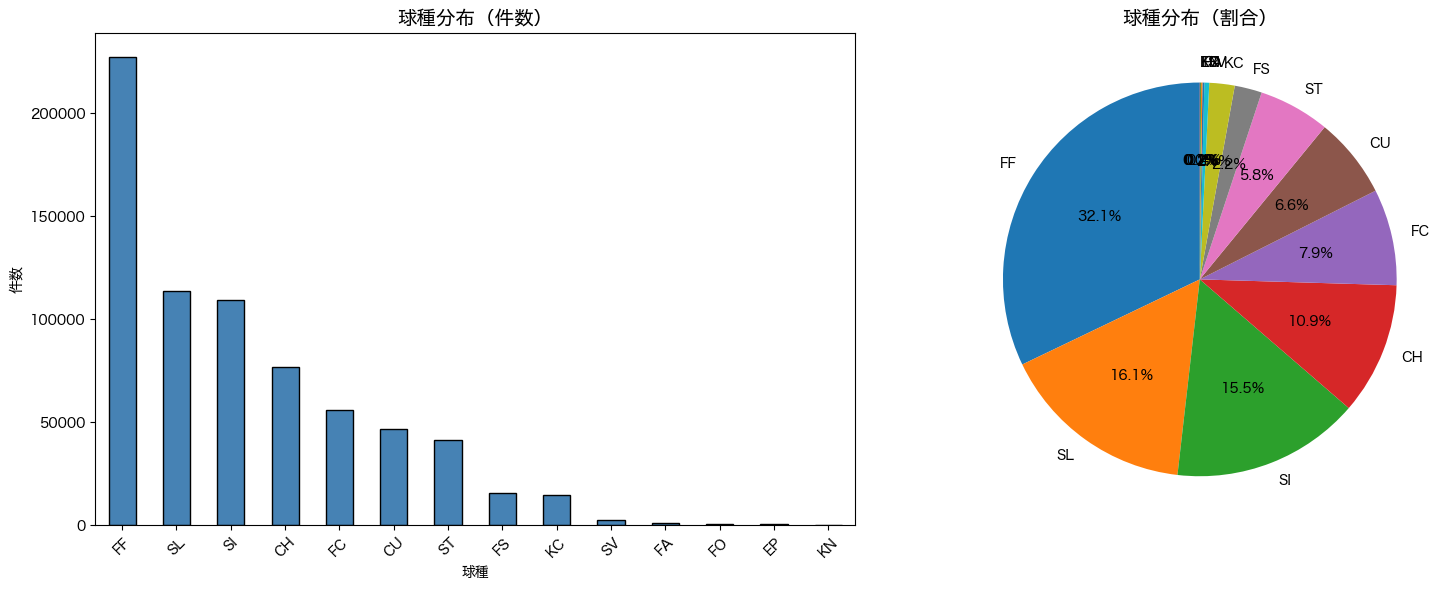

In [4]:
# 球種分布
print("=== 球種分布 ===")
pitch_counts = data['pitch_type'].value_counts()
print(pitch_counts)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 棒グラフ
pitch_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('球種分布（件数）', fontsize=14)
axes[0].set_xlabel('球種')
axes[0].set_ylabel('件数')
axes[0].tick_params(axis='x', rotation=45)

# 円グラフ
axes[1].pie(pitch_counts.values, labels=pitch_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('球種分布（割合）', fontsize=14)

plt.tight_layout()
plt.show()


## 1.5. 探索的データ分析 (EDA)

In [5]:
# 球種別統計
print("=== 球種別の特徴量統計 ===")
key_features = ['release_speed', 'pfx_x', 'pfx_z', 'release_spin_rate', 'speed_diff']
stats_by_pitch = data.groupby('pitch_type')[key_features].agg(['mean', 'std'])
print(stats_by_pitch.round(2))


=== 球種別の特徴量統計 ===
           release_speed       pfx_x       pfx_z       release_spin_rate  \
                    mean   std  mean   std  mean   std              mean   
pitch_type                                                                 
CH                 85.43  3.39 -1.19  0.28  0.47  0.38           1792.50   
CU                 79.01  3.63  0.77  0.42 -0.81  0.46           2547.24   
EP                 48.54  7.23 -0.03  0.58  1.39  0.39           1187.69   
FA                 67.69  9.47 -0.56  0.40  1.33  0.32           1652.31   
FC                 89.21  3.34  0.20  0.27  0.64  0.33           2389.15   
FF                 94.16  2.47 -0.62  0.34  1.31  0.24           2282.24   
FO                 82.98  1.56 -0.60  0.24  0.11  0.37           1079.64   
FS                 86.71  3.27 -0.92  0.35  0.28  0.33           1356.87   
KC                 81.96  3.45  0.53  0.46 -0.76  0.38           2445.86   
KN                 75.57  5.08 -0.31  0.55 -0.16  0.63            351.

=== 特徴量間の相関 ===


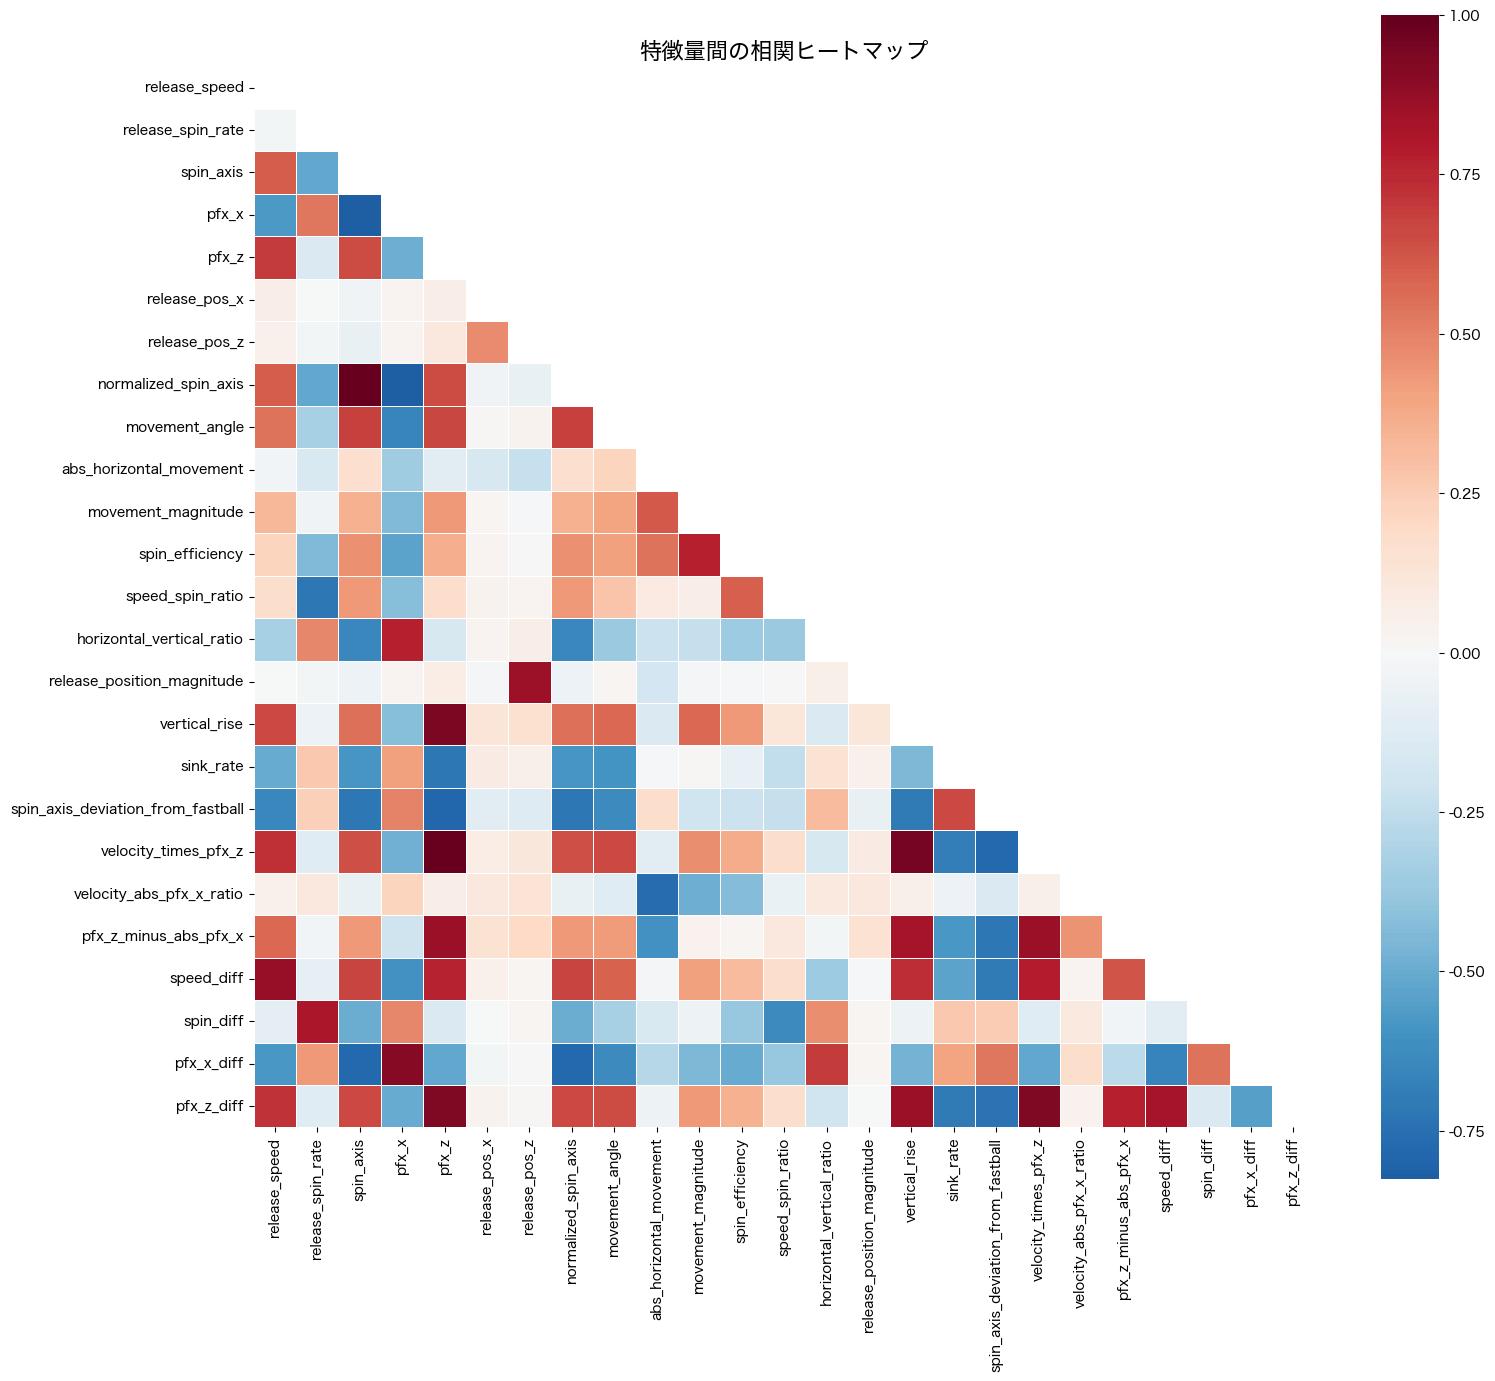


=== 高相関ペア (|r| > 0.7) ===
  spin_axis <-> normalized_spin_axis: 1.000
  pfx_z <-> velocity_times_pfx_z: 0.997
  vertical_rise <-> velocity_times_pfx_z: 0.955
  pfx_z <-> vertical_rise: 0.940
  pfx_z <-> pfx_z_diff: 0.934
  velocity_times_pfx_z <-> pfx_z_diff: 0.932
  pfx_x <-> pfx_x_diff: 0.907
  release_speed <-> speed_diff: 0.869
  vertical_rise <-> pfx_z_diff: 0.864
  pfx_z <-> pfx_z_minus_abs_pfx_x: 0.861


In [6]:
# 相関ヒートマップ
print("=== 特徴量間の相関 ===")

# 数値カラムのみ選択
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if 'pitcher' in numeric_cols:
    numeric_cols.remove('pitcher')

# 相関行列
corr_matrix = data[numeric_cols].corr()

# ヒートマップ
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0, 
            ax=ax, square=True, linewidths=0.5)
ax.set_title('特徴量間の相関ヒートマップ', fontsize=16)
plt.tight_layout()
plt.show()

# 高い相関を持つペア
print("\n=== 高相関ペア (|r| > 0.7) ===")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
for feat1, feat2, corr in high_corr[:10]:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")


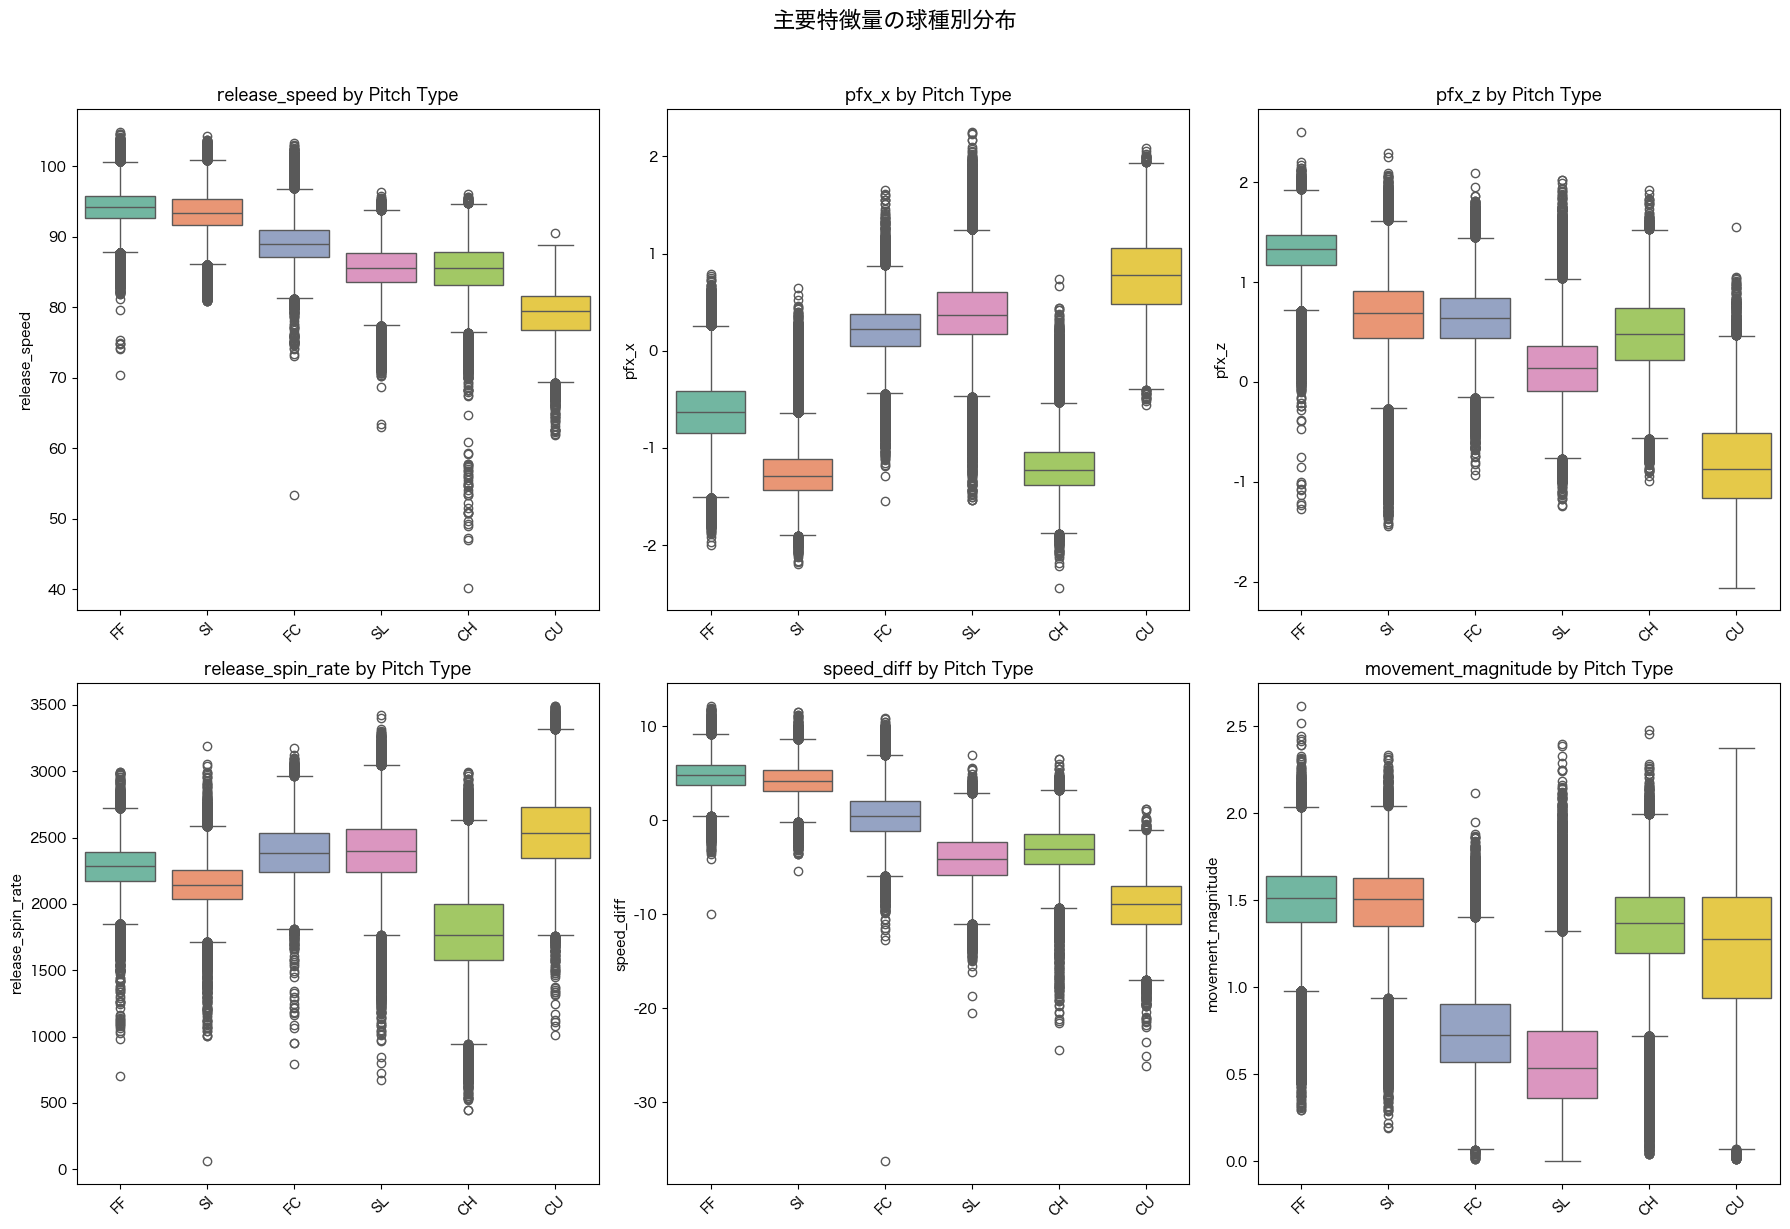

In [7]:
# 主要特徴量の箱ひげ図（球種別）
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

features_to_plot = ['release_speed', 'pfx_x', 'pfx_z', 'release_spin_rate', 'speed_diff', 'movement_magnitude']
main_pitches = ['FF', 'SI', 'FC', 'SL', 'CH', 'CU']
plot_data = data[data['pitch_type'].isin(main_pitches)]

for idx, feat in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    sns.boxplot(data=plot_data, x='pitch_type', y=feat, order=main_pitches, ax=ax, palette='Set2')
    ax.set_title(f'{feat} by Pitch Type', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('主要特徴量の球種別分布', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 2. 特徴量確認
投手相対特徴量を含む全特徴量を確認します。

In [8]:
# 特徴量リスト
base_features = [
    'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
    'release_pos_x', 'release_pos_z'
]

engineered_features = [
    'normalized_spin_axis', 'movement_angle', 'abs_horizontal_movement',
    'movement_magnitude', 'spin_efficiency', 'speed_spin_ratio',
    'horizontal_vertical_ratio', 'release_position_magnitude',
    'vertical_rise', 'sink_rate', 'spin_axis_deviation_from_fastball',
    'velocity_times_pfx_z', 'velocity_abs_pfx_x_ratio', 'pfx_z_minus_abs_pfx_x'
]

pitcher_relative_features = [
    'speed_diff', 'spin_diff', 'pfx_x_diff', 'pfx_z_diff'
]

all_features = base_features + engineered_features + pitcher_relative_features

# 存在確認
available_features = [f for f in all_features if f in train_data.columns]
missing_features = [f for f in all_features if f not in train_data.columns]

print(f"利用可能な特徴量: {len(available_features)}個")
print(f"欠損特徴量: {missing_features}")
print(f"\n=== 特徴量リスト ({len(available_features)}個) ===")
print("【基本特徴量】")
for f in base_features:
    if f in available_features:
        print(f"  ✓ {f}")
print("\n【エンジニアリング特徴量】")
for f in engineered_features:
    if f in available_features:
        print(f"  ✓ {f}")
print("\n【投手相対特徴量】★NEW")
for f in pitcher_relative_features:
    if f in available_features:
        print(f"  ★ {f}")


利用可能な特徴量: 25個
欠損特徴量: []

=== 特徴量リスト (25個) ===
【基本特徴量】
  ✓ release_speed
  ✓ release_spin_rate
  ✓ spin_axis
  ✓ pfx_x
  ✓ pfx_z
  ✓ release_pos_x
  ✓ release_pos_z

【エンジニアリング特徴量】
  ✓ normalized_spin_axis
  ✓ movement_angle
  ✓ abs_horizontal_movement
  ✓ movement_magnitude
  ✓ spin_efficiency
  ✓ speed_spin_ratio
  ✓ horizontal_vertical_ratio
  ✓ release_position_magnitude
  ✓ vertical_rise
  ✓ sink_rate
  ✓ spin_axis_deviation_from_fastball
  ✓ velocity_times_pfx_z
  ✓ velocity_abs_pfx_x_ratio
  ✓ pfx_z_minus_abs_pfx_x

【投手相対特徴量】★NEW
  ★ speed_diff
  ★ spin_diff
  ★ pfx_x_diff
  ★ pfx_z_diff


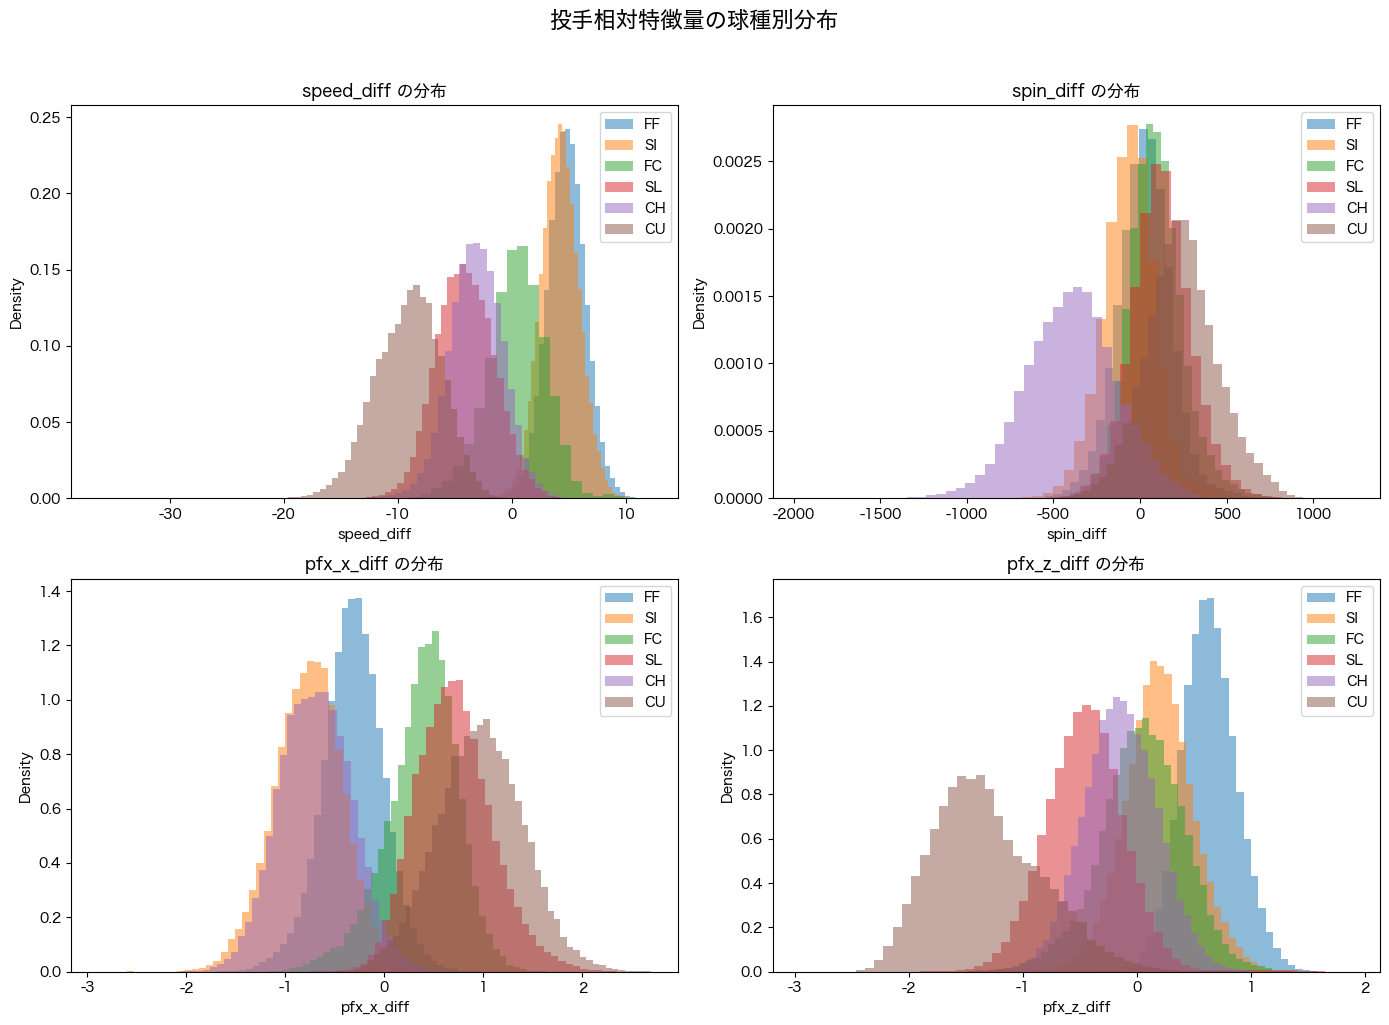

In [9]:
# 投手相対特徴量の分布（球種別）
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, feat in enumerate(pitcher_relative_features):
    ax = axes[idx // 2, idx % 2]
    for pitch in main_pitches:
        subset = data[data['pitch_type'] == pitch][feat]
        ax.hist(subset, bins=50, alpha=0.5, label=pitch, density=True)
    ax.set_title(f'{feat} の分布', fontsize=12)
    ax.set_xlabel(feat)
    ax.set_ylabel('Density')
    ax.legend()

plt.suptitle('投手相対特徴量の球種別分布', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 3. データ準備

In [10]:
# ターゲット変数のエンコード
le = LabelEncoder()
y_train = le.fit_transform(train_data['pitch_type'])
y_test = le.transform(test_data['pitch_type'])

X_train = train_data[available_features]
X_test = test_data[available_features]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nクラス数: {len(le.classes_)}")
print(f"クラス: {list(le.classes_)}")

# クラス分布
print("\n=== クラス分布 (学習データ) ===")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    print(f"  {le.classes_[idx]}: {count:,} ({count/len(y_train)*100:.1f}%)")


X_train shape: (495322, 25)
X_test shape: (212282, 25)

クラス数: 14
クラス: ['CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'KC', 'KN', 'SI', 'SL', 'ST', 'SV']

=== クラス分布 (学習データ) ===
  CH: 53,821 (10.9%)
  CU: 32,841 (6.6%)
  EP: 390 (0.1%)
  FA: 779 (0.2%)
  FC: 39,192 (7.9%)
  FF: 159,076 (32.1%)
  FO: 536 (0.1%)
  FS: 11,104 (2.2%)
  KC: 10,289 (2.1%)
  KN: 134 (0.0%)
  SI: 76,629 (15.5%)
  SL: 79,619 (16.1%)
  ST: 28,945 (5.8%)
  SV: 1,967 (0.4%)


## 4. ベースラインモデル（デフォルトパラメータ）
最適化前のモデル性能を確認します。

In [11]:
# ベースラインモデル（最適化前）
print("=== ベースラインモデル（最適化前）===")
baseline_results = {}

# Random Forest
print("Training RandomForest baseline...")
rf_baseline = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)
rf_base_acc = accuracy_score(y_test, rf_baseline.predict(X_test))
rf_base_f1 = f1_score(y_test, rf_baseline.predict(X_test), average='weighted')
baseline_results['RandomForest'] = {'acc': rf_base_acc, 'f1': rf_base_f1}
print(f"  RandomForest: Accuracy {rf_base_acc:.4f}, F1 {rf_base_f1:.4f}")

# XGBoost
print("Training XGBoost baseline...")
xgb_baseline = xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1)
xgb_baseline.fit(X_train, y_train)
xgb_base_acc = accuracy_score(y_test, xgb_baseline.predict(X_test))
xgb_base_f1 = f1_score(y_test, xgb_baseline.predict(X_test), average='weighted')
baseline_results['XGBoost'] = {'acc': xgb_base_acc, 'f1': xgb_base_f1}
print(f"  XGBoost: Accuracy {xgb_base_acc:.4f}, F1 {xgb_base_f1:.4f}")

# LightGBM
print("Training LightGBM baseline...")
lgb_baseline = lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1, verbose=-1)
lgb_baseline.fit(X_train, y_train)
lgb_base_acc = accuracy_score(y_test, lgb_baseline.predict(X_test))
lgb_base_f1 = f1_score(y_test, lgb_baseline.predict(X_test), average='weighted')
baseline_results['LightGBM'] = {'acc': lgb_base_acc, 'f1': lgb_base_f1}
print(f"  LightGBM: Accuracy {lgb_base_acc:.4f}, F1 {lgb_base_f1:.4f}")

# 結果テーブル
print("\n=== ベースライン結果 ===")
baseline_df = pd.DataFrame(baseline_results).T
baseline_df.columns = ['Accuracy', 'F1 Score']
print(baseline_df.round(4))


=== ベースラインモデル（最適化前）===
Training RandomForest baseline...
  RandomForest: Accuracy 0.8670, F1 0.8621
Training XGBoost baseline...
  XGBoost: Accuracy 0.9341, F1 0.9339
Training LightGBM baseline...
  LightGBM: Accuracy 0.7951, F1 0.7969

=== ベースライン結果 ===
              Accuracy  F1 Score
RandomForest    0.8670    0.8621
XGBoost         0.9341    0.9339
LightGBM        0.7951    0.7969


## 5. GridSearchによるハイパーパラメータ最適化
asao_1313で最適化されたパラメータを使用します。

In [12]:
# 最適化されたパラメータ（asao_1313のGridSearch結果より）
optimized_params = {
    'XGBoost': {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'min_child_weight': 0.5},
    'LightGBM': {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05},
    'RandomForest': {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 1}
}

print("=== 最適化パラメータ ===")
for model, params in optimized_params.items():
    print(f"\n{model}:")
    for k, v in params.items():
        print(f"  {k}: {v}")


=== 最適化パラメータ ===

XGBoost:
  n_estimators: 200
  max_depth: 10
  learning_rate: 0.1
  min_child_weight: 0.5

LightGBM:
  n_estimators: 100
  max_depth: 7
  learning_rate: 0.05

RandomForest:
  n_estimators: 200
  max_depth: None
  min_samples_leaf: 1


In [13]:
# 最適化パラメータでモデル学習
optimized_results = {}

# XGBoost
print("\nTraining XGBoost (optimized)...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200, max_depth=10, learning_rate=0.1, min_child_weight=0.5,
    random_state=42, n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')
optimized_results['XGBoost'] = {'acc': xgb_acc, 'f1': xgb_f1}
print(f"  XGBoost: Accuracy {xgb_acc:.4f}, F1 {xgb_f1:.4f}")

# LightGBM
print("Training LightGBM (optimized)...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=100, max_depth=7, learning_rate=0.05,
    random_state=42, n_jobs=-1, verbose=-1
)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_acc = accuracy_score(y_test, lgb_pred)
lgb_f1 = f1_score(y_test, lgb_pred, average='weighted')
optimized_results['LightGBM'] = {'acc': lgb_acc, 'f1': lgb_f1}
print(f"  LightGBM: Accuracy {lgb_acc:.4f}, F1 {lgb_f1:.4f}")

# RandomForest
print("Training RandomForest (optimized)...")
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=None, min_samples_leaf=1,
    random_state=42, n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')
optimized_results['RandomForest'] = {'acc': rf_acc, 'f1': rf_f1}
print(f"  RandomForest: Accuracy {rf_acc:.4f}, F1 {rf_f1:.4f}")



Training XGBoost (optimized)...
  XGBoost: Accuracy 0.9519, F1 0.9518
Training LightGBM (optimized)...
  LightGBM: Accuracy 0.8936, F1 0.8939
Training RandomForest (optimized)...
  RandomForest: Accuracy 0.9384, F1 0.9380



=== モデル比較（ベースライン vs 最適化）===
       Model  Baseline Acc  Optimized Acc  Improvement
     XGBoost      0.934125       0.951894     0.017769
    LightGBM      0.795089       0.893632     0.098543
RandomForest      0.866998       0.938360     0.071363


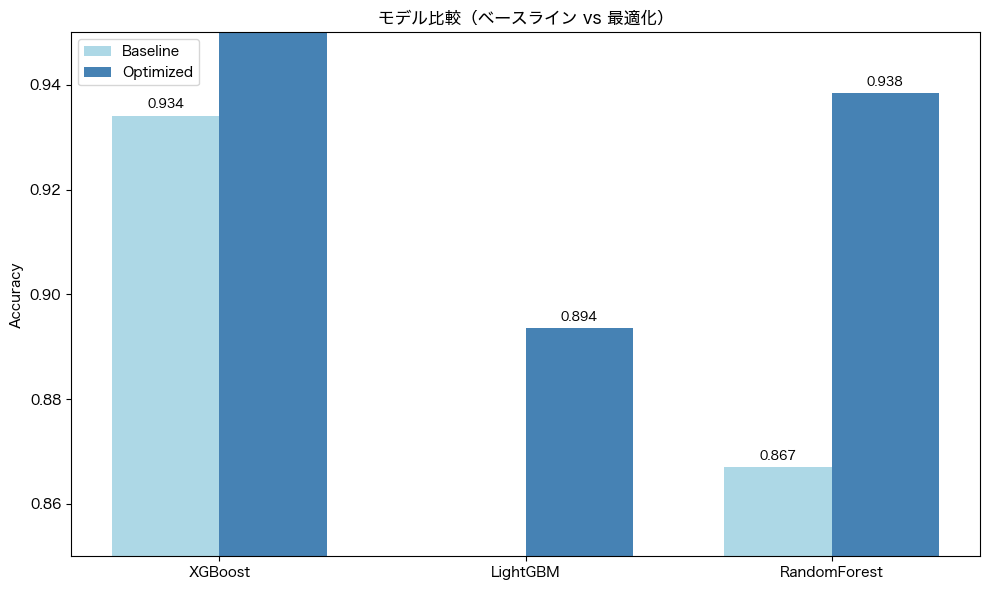

In [14]:
# モデル比較テーブル
print("\n=== モデル比較（ベースライン vs 最適化）===")
comparison_data = []
for model in ['XGBoost', 'LightGBM', 'RandomForest']:
    comparison_data.append({
        'Model': model,
        'Baseline Acc': baseline_results[model]['acc'],
        'Optimized Acc': optimized_results[model]['acc'],
        'Improvement': optimized_results[model]['acc'] - baseline_results[model]['acc']
    })
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# 可視化
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(3)
width = 0.35
models = ['XGBoost', 'LightGBM', 'RandomForest']
baseline_accs = [baseline_results[m]['acc'] for m in models]
optimized_accs = [optimized_results[m]['acc'] for m in models]

bars1 = ax.bar(x - width/2, baseline_accs, width, label='Baseline', color='lightblue')
bars2 = ax.bar(x + width/2, optimized_accs, width, label='Optimized', color='steelblue')

ax.set_ylabel('Accuracy')
ax.set_title('モデル比較（ベースライン vs 最適化）')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim([0.85, 0.95])

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


## 6. 最終モデル選択
XGBoost単体がアンサンブルより高精度のため、XGBoostを最終モデルとして採用します。

In [15]:
# === 最終モデル: XGBoost単体 ===
print("=== 最終モデル: XGBoost単体 ===")
print("※ XGBoost単体がアンサンブルより高精度のため、XGBoostを採用")

# XGBoostの予測を最終予測として使用
y_pred = xgb_pred
final_acc = xgb_acc
final_f1 = xgb_f1

print(f"\n★ XGBoost Accuracy: {final_acc:.4f}")
print(f"★ XGBoost F1 Score (weighted): {final_f1:.4f}")

# 全モデル比較テーブル
print(f"\n=== 全モデル比較 ===")
all_results = {
    '★ XGBoost (採用)': {'Accuracy': xgb_acc, 'F1': xgb_f1},
    'LightGBM': {'Accuracy': lgb_acc, 'F1': lgb_f1},
    'RandomForest': {'Accuracy': rf_acc, 'F1': rf_f1},
}
all_results_df = pd.DataFrame(all_results).T
print(all_results_df.round(4))

print(f"\n--- ベースライン比較（同一CSV）---")
print(f"asao_1321 (投手特徴量なし): Accuracy 0.904, F1 0.903")
print(f"本モデル (XGBoost単体):     Accuracy {final_acc:.4f}, F1 {final_f1:.4f}")
print(f"改善幅: Accuracy {final_acc - 0.904:+.4f}, F1 {final_f1 - 0.903:+.4f}")


=== 最終モデル: XGBoost単体 ===
※ XGBoost単体がアンサンブルより高精度のため、XGBoostを採用

★ XGBoost Accuracy: 0.9519
★ XGBoost F1 Score (weighted): 0.9518

=== 全モデル比較 ===
                Accuracy      F1
★ XGBoost (採用)    0.9519  0.9518
LightGBM          0.8936  0.8939
RandomForest      0.9384  0.9380

--- ベースライン比較（同一CSV）---
asao_1321 (投手特徴量なし): Accuracy 0.904, F1 0.903
本モデル (XGBoost単体):     Accuracy 0.9519, F1 0.9518
改善幅: Accuracy +0.0479, F1 +0.0488


## 7. 分類レポート・混同行列

In [16]:
# 分類レポート
print("=== 分類レポート ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# キーメトリクス
report = classification_report(y_test, y_pred, output_dict=True, target_names=le.classes_)
print("\n=== 重要指標 (同一CSVのasao_1321と比較) ===")
print(f"FC Recall: {report['FC']['recall']:.4f} (asao_1321: 0.75, 改善: {report['FC']['recall']-0.75:+.2f})")
print(f"SI Recall: {report['SI']['recall']:.4f} (asao_1321: 0.93, 改善: {report['SI']['recall']-0.93:+.2f})")
print(f"SL Recall: {report['SL']['recall']:.4f}")
print(f"FF Recall: {report['FF']['recall']:.4f}")


=== 分類レポート ===
              precision    recall  f1-score   support

          CH       0.97      0.98      0.98     23066
          CU       0.95      0.94      0.94     14075
          EP       0.95      0.89      0.92       167
          FA       0.94      0.93      0.93       334
          FC       0.91      0.88      0.90     16797
          FF       0.98      0.98      0.98     68175
          FO       0.92      0.93      0.93       230
          FS       0.95      0.88      0.92      4759
          KC       0.96      0.89      0.92      4410
          KN       0.89      0.88      0.89        58
          SI       0.97      0.96      0.96     32841
          SL       0.91      0.93      0.92     34122
          ST       0.90      0.92      0.91     12405
          SV       0.95      0.82      0.88       843

    accuracy                           0.95    212282
   macro avg       0.94      0.92      0.93    212282
weighted avg       0.95      0.95      0.95    212282


=== 重要指標 

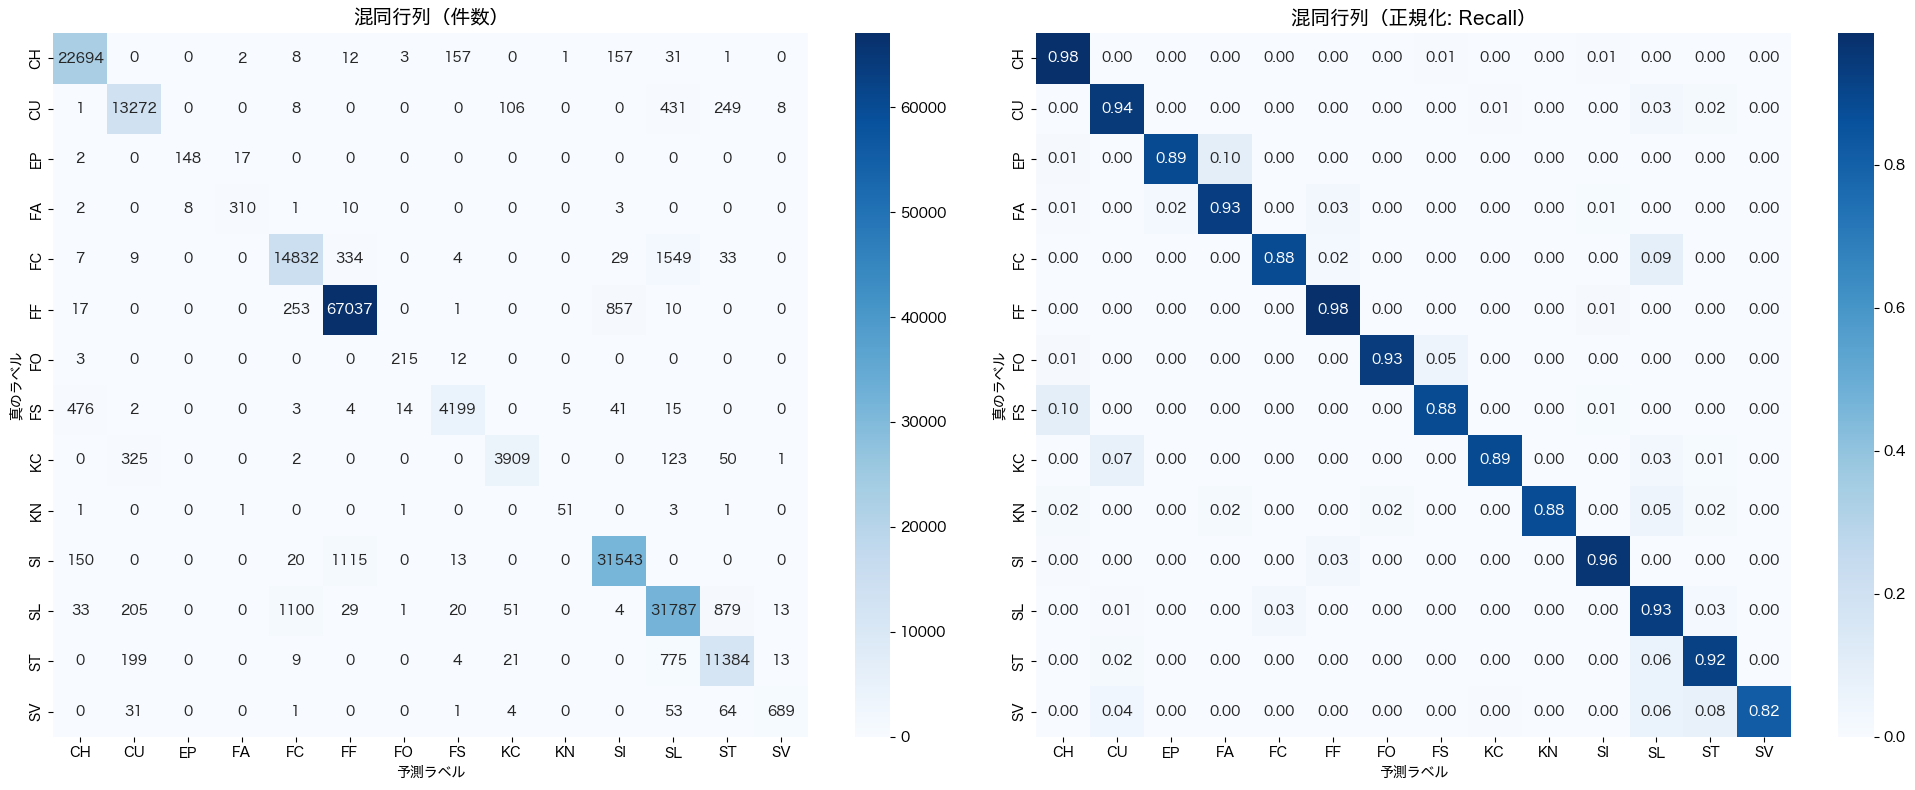

In [17]:
# 混同行列
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 件数ベース
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title('混同行列（件数）', fontsize=14)
axes[0].set_xlabel('予測ラベル')
axes[0].set_ylabel('真のラベル')

# 正規化（行方向=Recall）
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title('混同行列（正規化: Recall）', fontsize=14)
axes[1].set_xlabel('予測ラベル')
axes[1].set_ylabel('真のラベル')

plt.tight_layout()
plt.show()


## 8. 特徴量重要度

=== 特徴量重要度 (Top 15) ===
                          feature  xgb_importance  lgb_importance  rf_importance  avg_importance
                    release_pos_x        0.008150            3879       0.028295     1293.012148
                    release_speed        0.010089            3461       0.060735     1153.690275
                       speed_diff        0.046920            3382       0.110802     1127.385907
                    release_pos_z        0.007569            2997       0.022946      999.010172
                       pfx_x_diff        0.007166            2603       0.038444      867.681870
       release_position_magnitude        0.006741            2539       0.021854      846.342865
                        spin_diff        0.021387            2441       0.030355      813.683914
                        spin_axis        0.023512            2314       0.034173      771.352561
                 speed_spin_ratio        0.015432            2198       0.027406      732.680946
      

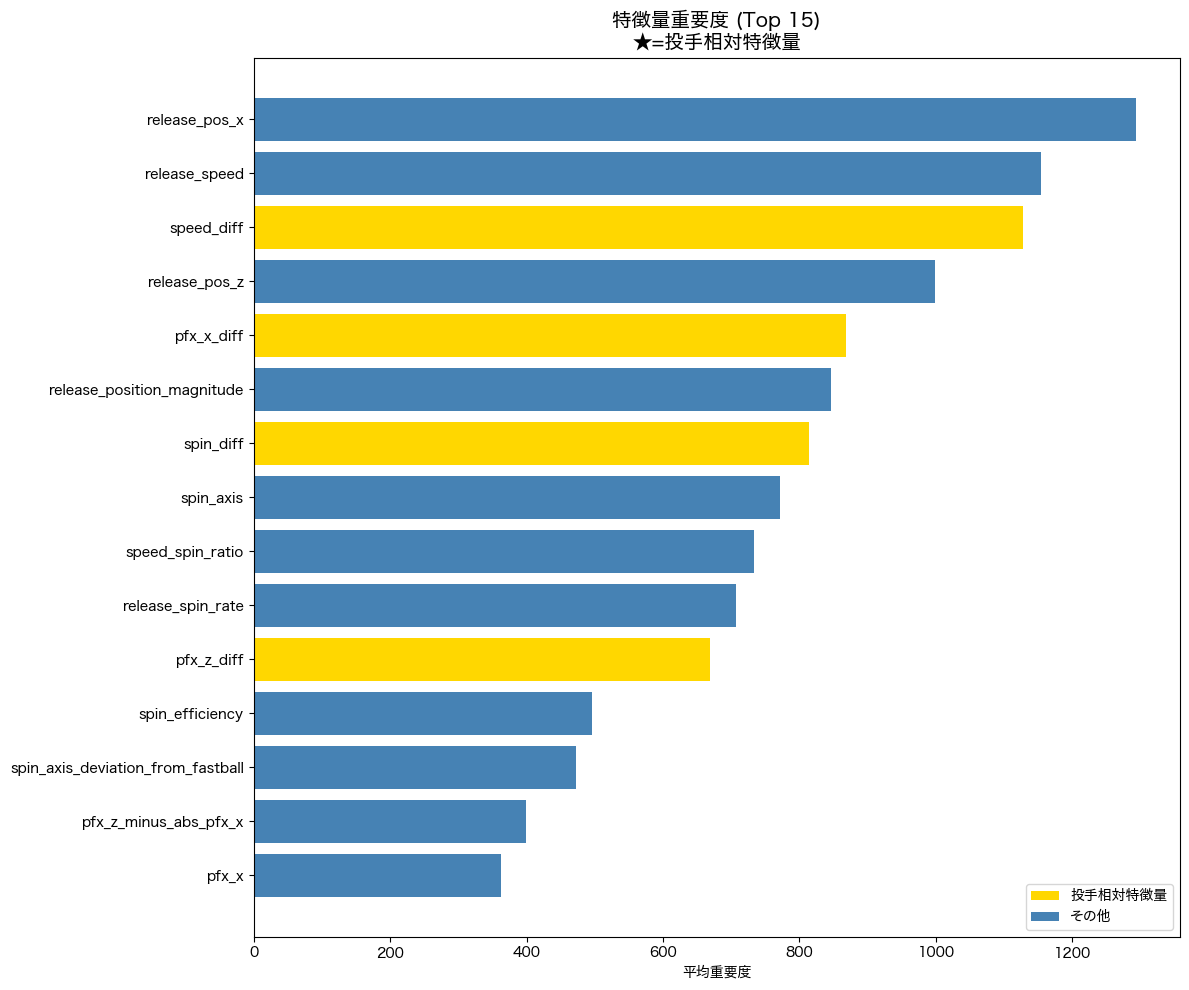


=== 投手相対特徴量の重要度 ===
   feature  avg_importance
speed_diff     1127.385907
pfx_x_diff      867.681870
 spin_diff      813.683914
pfx_z_diff      669.016966

投手相対特徴量の合計重要度: 3477.7687 (347776.9%)


In [18]:
# 3モデルの特徴量重要度
importance_df = pd.DataFrame({
    'feature': available_features,
    'xgb_importance': xgb_model.feature_importances_,
    'lgb_importance': lgb_model.feature_importances_,
    'rf_importance': rf_model.feature_importances_
})

# 平均重要度
importance_df['avg_importance'] = (
    importance_df['xgb_importance'] + 
    importance_df['lgb_importance'] + 
    importance_df['rf_importance']
) / 3

importance_df = importance_df.sort_values('avg_importance', ascending=False)

print("=== 特徴量重要度 (Top 15) ===")
print(importance_df[['feature', 'xgb_importance', 'lgb_importance', 'rf_importance', 'avg_importance']].head(15).to_string(index=False))

# 可視化
fig, ax = plt.subplots(figsize=(12, 10))
top15 = importance_df.head(15)
colors = ['gold' if f in pitcher_relative_features else 'steelblue' for f in top15['feature']]
ax.barh(top15['feature'], top15['avg_importance'], color=colors)
ax.set_xlabel('平均重要度')
ax.set_title('特徴量重要度 (Top 15)\n★=投手相対特徴量', fontsize=14)
ax.invert_yaxis()

# 凡例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='gold', label='投手相対特徴量'),
                   Patch(facecolor='steelblue', label='その他')]
ax.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

# 投手相対特徴量の重要度
print("\n=== 投手相対特徴量の重要度 ===")
pitcher_imp = importance_df[importance_df['feature'].isin(pitcher_relative_features)]
print(pitcher_imp[['feature', 'avg_importance']].to_string(index=False))
total_pitcher_imp = pitcher_imp['avg_importance'].sum()
print(f"\n投手相対特徴量の合計重要度: {total_pitcher_imp:.4f} ({total_pitcher_imp*100:.1f}%)")


## 9. SHAP分析 (説明可能性)

=== SHAP分析 ===
Explainerを作成中...
DEBUG: X_sample shape: (1000, 25)
DEBUG: shap_values shape: (1000, 25, 14)
DEBUG: Converted 3D array (samples, features, classes) to list of 14 arrays

1. SHAP Summary Plot (Bar)...


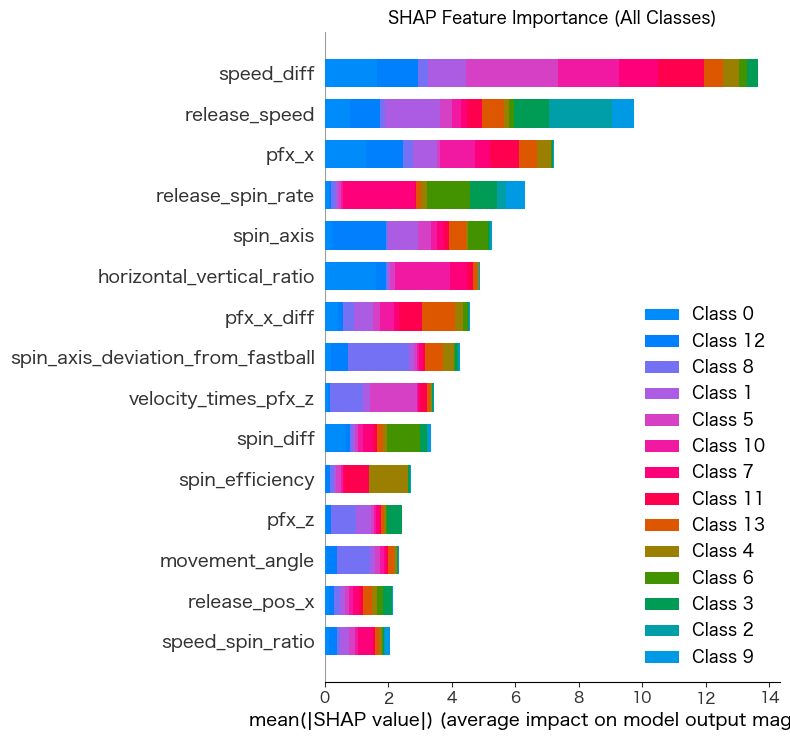


2. SHAP Beeswarm Plot (FC class)...
DEBUG: class_shap_values shape: (1000, 25)


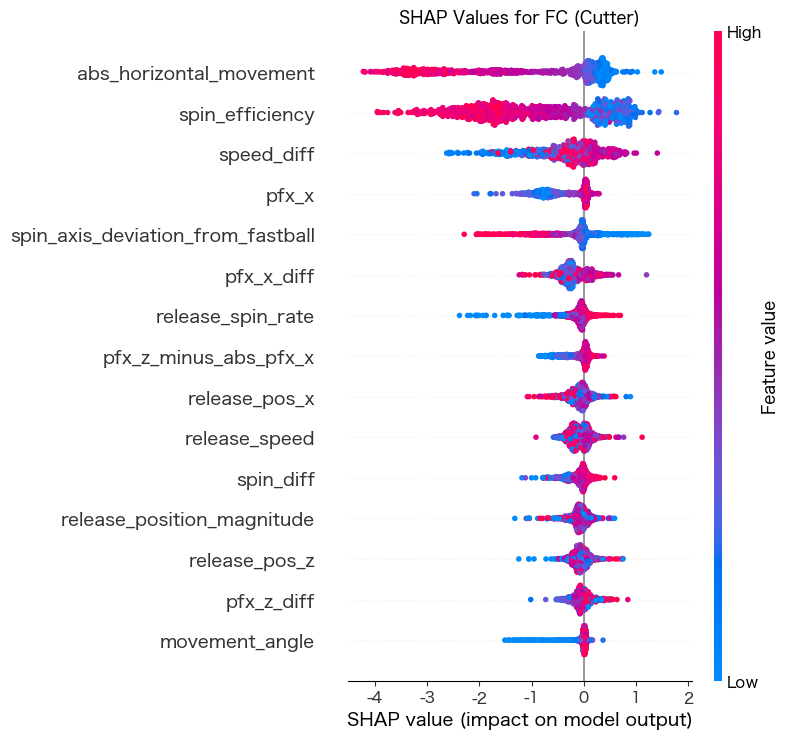

In [22]:
if SHAP_AVAILABLE:
    print("=== SHAP分析 ===")
    import numpy as np
    
    # サンプリング（計算時間短縮）
    sample_size = min(1000, len(X_test))
    X_sample = X_test.sample(n=sample_size, random_state=42)
    
    # TreeExplainer
    print("Explainerを作成中...")
    explainer = shap.TreeExplainer(xgb_model)
    # 互換性のために一旦 numpy array 形式で取得
    shap_values_orig = explainer.shap_values(X_sample)
    
    n_features = X_sample.shape[1]
    n_samples = X_sample.shape[0]
    
    print(f"DEBUG: X_sample shape: {X_sample.shape}")
    
    # 形状の自動調整ロジック
    if isinstance(shap_values_orig, list):
        print(f"DEBUG: shap_values is a list of length {len(shap_values_orig)}")
        # 各要素が (samples, features+1) の場合、バイアス項を削除
        if shap_values_orig[0].shape[1] == n_features + 1:
            print("各クラスのSHAP値からバイアス項を削除します")
            shap_values = [v[:, :n_features] for v in shap_values_orig]
        else:
            shap_values = shap_values_orig
    elif isinstance(shap_values_orig, np.ndarray):
        print(f"DEBUG: shap_values shape: {shap_values_orig.shape}")
        # 3D配列の場合の処理
        if shap_values_orig.ndim == 3:
            # SHAPのsummary_plot (bar, multi-class) は list 形式であることを期待する場合が多い
            # (samples, features, classes) -> list of (samples, features)
            if shap_values_orig.shape[1] == n_features or shap_values_orig.shape[1] == n_features + 1:
                # (samples, features, classes)
                slc = n_features
                shap_values = [shap_values_orig[:, :slc, i] for i in range(shap_values_orig.shape[2])]
                print(f"DEBUG: Converted 3D array (samples, features, classes) to list of {len(shap_values)} arrays")
            elif shap_values_orig.shape[2] == n_features or shap_values_orig.shape[2] == n_features + 1:
                # (classes, samples, features)
                slc = n_features
                shap_values = [shap_values_orig[i, :, :slc] for i in range(shap_values_orig.shape[0])]
                print(f"DEBUG: Converted 3D array (classes, samples, features) to list of {len(shap_values)} arrays")
            else:
                shap_values = shap_values_orig
        elif shap_values_orig.ndim == 2 and shap_values_orig.shape[1] == n_features + 1:
            shap_values = shap_values_orig[:, :n_features]
        else:
            shap_values = shap_values_orig
    else:
        shap_values = shap_values_orig
    
    # Summary Plot (Bar) - 全体
    print("\n1. SHAP Summary Plot (Bar)...")
    try:
        fig = plt.figure(figsize=(10, 6))
        # shap.summary_plotに情報を渡す
        shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=15, show=False)
        plt.title("SHAP Feature Importance (All Classes)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Summary Plot (Bar) でエラーが発生しました: {e}")

    # Beeswarm Plot (特定クラス: FC)
    print("\n2. SHAP Beeswarm Plot (FC class)...")
    try:
        class_names = list(le.classes_)
        if 'FC' in class_names:
            fc_idx = class_names.index('FC')
            # shap_valuesは調整済みのlistまたはarray
            class_shap_values = shap_values[fc_idx]
            
            print(f"DEBUG: class_shap_values shape: {class_shap_values.shape}")
            fig = plt.figure(figsize=(10, 6))
            shap.summary_plot(class_shap_values, X_sample, max_display=15, show=False)
            plt.title("SHAP Values for FC (Cutter)")
            plt.tight_layout()
            plt.show()
        else:
            print("FCクラスが見つかりません。")
    except Exception as e:
        print(f"Beeswarm Plot でエラーが発生しました: {e}")

else:
    print("SHAP is not available. Skipping SHAP analysis.")

## 10. 誤分類分析

全体誤分類率: 0.0481 (4.81%)

=== 球種別誤分類率 ===
  SV: 0.1827 (18.3%)
  KN: 0.1207 (12.1%)
  FS: 0.1177 (11.8%)
  FC: 0.1170 (11.7%)
  EP: 0.1138 (11.4%)
  KC: 0.1136 (11.4%)
  ST: 0.0823 (8.2%)
  FA: 0.0719 (7.2%)
  SL: 0.0684 (6.8%)
  FO: 0.0652 (6.5%)
  CU: 0.0571 (5.7%)
  SI: 0.0395 (4.0%)
  FF: 0.0167 (1.7%)
  CH: 0.0161 (1.6%)


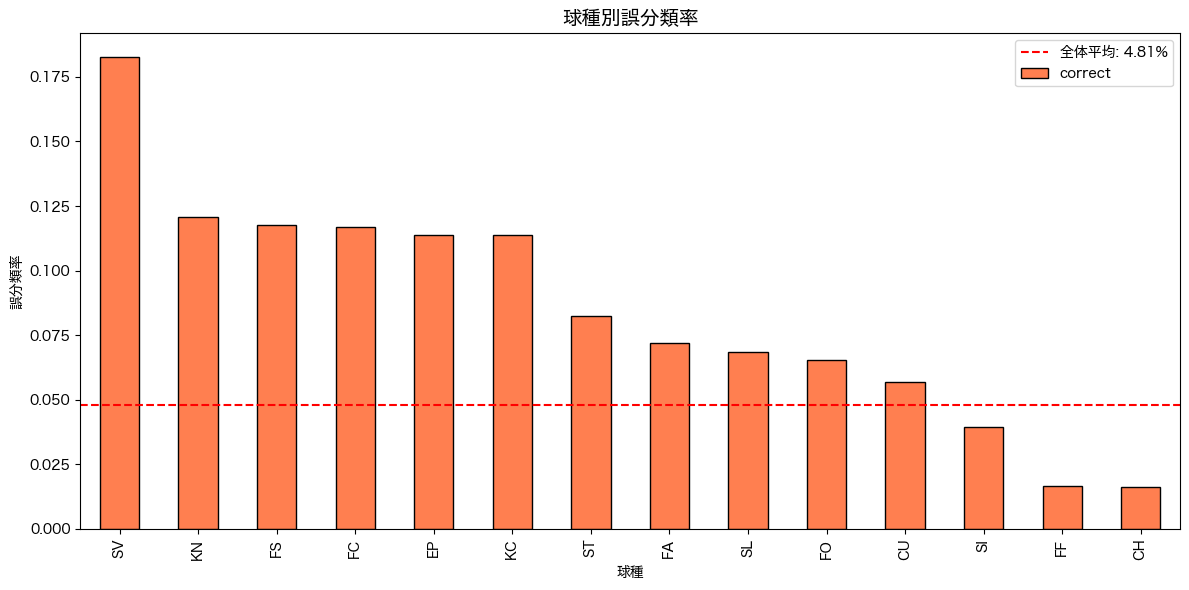

In [23]:
# 予測結果をDataFrameに追加
test_results = test_data.copy()
test_results['true_label'] = le.inverse_transform(y_test)
test_results['pred_label'] = le.inverse_transform(y_pred)
test_results['correct'] = test_results['true_label'] == test_results['pred_label']

# 誤分類率
error_rate = 1 - test_results['correct'].mean()
print(f"全体誤分類率: {error_rate:.4f} ({error_rate*100:.2f}%)")

# 球種別誤分類率
print("\n=== 球種別誤分類率 ===")
error_by_pitch = test_results.groupby('true_label')['correct'].apply(lambda x: 1 - x.mean())
error_by_pitch = error_by_pitch.sort_values(ascending=False)
for pitch, err in error_by_pitch.items():
    print(f"  {pitch}: {err:.4f} ({err*100:.1f}%)")

# 可視化
fig, ax = plt.subplots(figsize=(12, 6))
error_by_pitch.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
ax.set_title('球種別誤分類率', fontsize=14)
ax.set_xlabel('球種')
ax.set_ylabel('誤分類率')
ax.axhline(y=error_rate, color='red', linestyle='--', label=f'全体平均: {error_rate:.2%}')
ax.legend()
plt.tight_layout()
plt.show()



=== FC vs SL 誤分類分析 ===
FC → SL 誤分類: 1,549件 / 16,797件 (9.2%)
SL → FC 誤分類: 1,100件 / 34,122件 (3.2%)


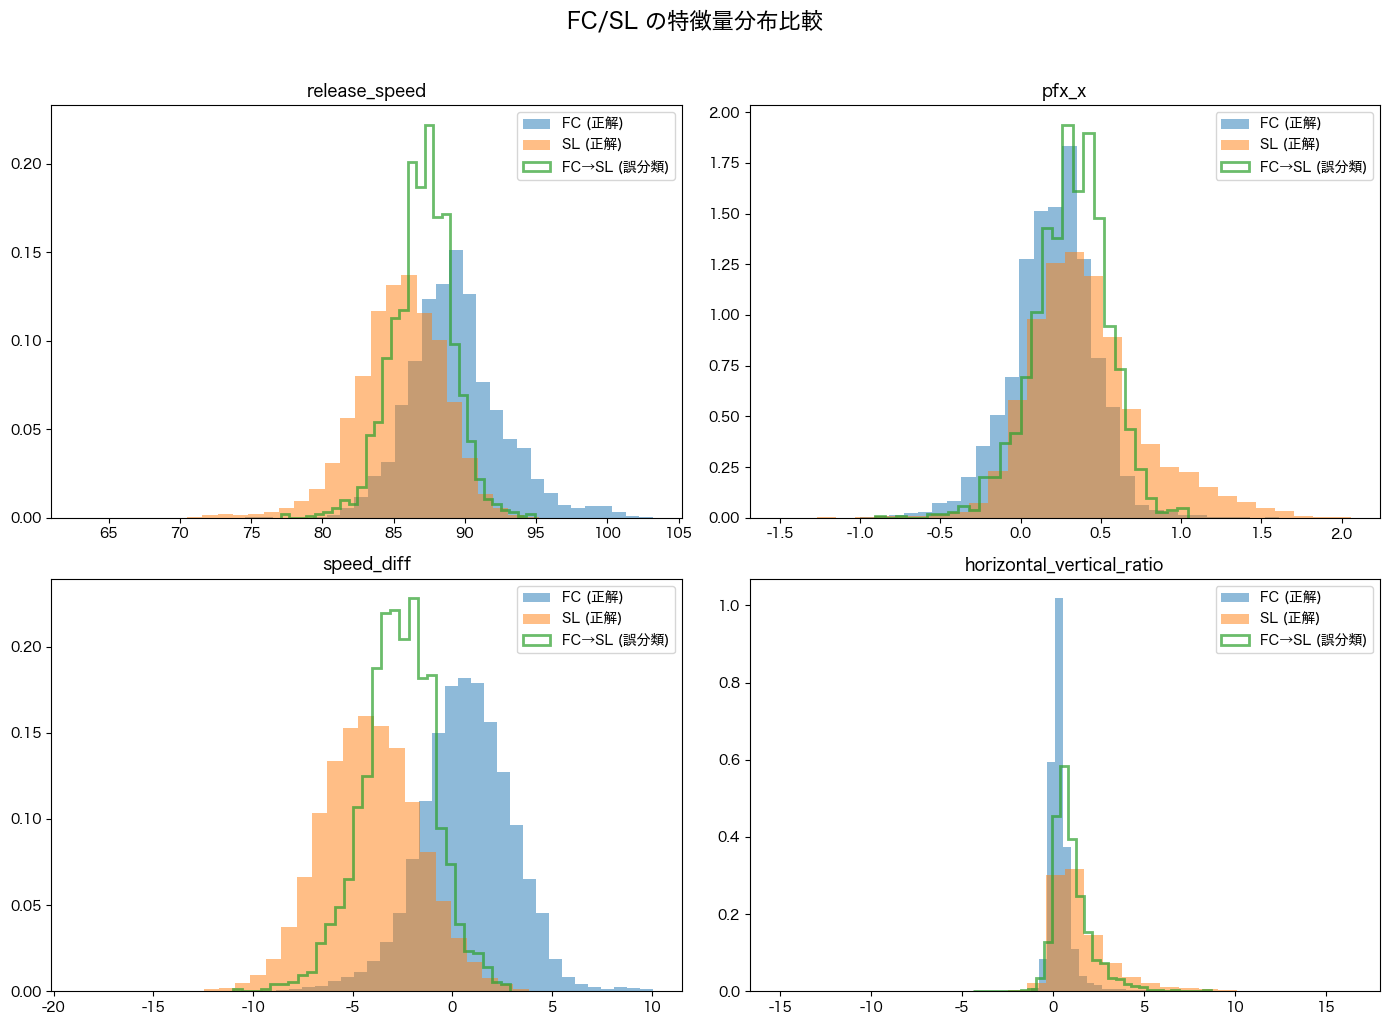

In [24]:
# FC vs SL の詳細分析
print("\n=== FC vs SL 誤分類分析 ===")
fc_sl_data = test_results[test_results['true_label'].isin(['FC', 'SL'])]

# 誤分類件数
fc_to_sl = fc_sl_data[(fc_sl_data['true_label'] == 'FC') & (fc_sl_data['pred_label'] == 'SL')]
sl_to_fc = fc_sl_data[(fc_sl_data['true_label'] == 'SL') & (fc_sl_data['pred_label'] == 'FC')]
fc_total = len(fc_sl_data[fc_sl_data['true_label'] == 'FC'])
sl_total = len(fc_sl_data[fc_sl_data['true_label'] == 'SL'])

print(f"FC → SL 誤分類: {len(fc_to_sl):,}件 / {fc_total:,}件 ({len(fc_to_sl)/fc_total*100:.1f}%)")
print(f"SL → FC 誤分類: {len(sl_to_fc):,}件 / {sl_total:,}件 ({len(sl_to_fc)/sl_total*100:.1f}%)")

# 特徴量分布比較
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fc_correct = fc_sl_data[(fc_sl_data['true_label'] == 'FC') & (fc_sl_data['correct'])]
sl_correct = fc_sl_data[(fc_sl_data['true_label'] == 'SL') & (fc_sl_data['correct'])]

features_for_analysis = ['release_speed', 'pfx_x', 'speed_diff', 'horizontal_vertical_ratio']
for idx, feat in enumerate(features_for_analysis):
    ax = axes[idx // 2, idx % 2]
    ax.hist(fc_correct[feat], bins=30, alpha=0.5, label='FC (正解)', density=True)
    ax.hist(sl_correct[feat], bins=30, alpha=0.5, label='SL (正解)', density=True)
    ax.hist(fc_to_sl[feat], bins=30, alpha=0.7, label='FC→SL (誤分類)', density=True, histtype='step', linewidth=2)
    ax.set_title(f'{feat}')
    ax.legend()

plt.suptitle('FC/SL の特徴量分布比較', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 11. まとめ

In [25]:
print("="*70)
print("=== 最終結果サマリー ===")
print("="*70)
print(f"\n★ 最終モデル: XGBoost単体")
print(f"データ: train_pitcher_v2.csv / test_pitcher_v2.csv")
print(f"特徴量: {len(available_features)}個 (投手相対特徴量4個を含む)")

print(f"\n--- パフォーマンス ---")
print(f"Accuracy:  {final_acc:.4f}")
print(f"F1 Score:  {final_f1:.4f}")

print(f"\n--- ベースライン比較（同一CSV: train_pitcher_v2.csv）---")
print(f"{'モデル':<30} {'Accuracy':<12} {'FC Recall':<12}")
print("-"*55)
print(f"{'asao_1321 (投手特徴量なし)':<30} {'0.904':<12} {'0.75':<12}")
print(f"{'★ 本モデル (XGBoost単体)':<30} {final_acc:<12.4f} {report['FC']['recall']:<12.4f}")
print(f"{'改善幅':<30} {final_acc - 0.904:<+12.4f} {report['FC']['recall']-0.75:<+12.4f}")

print(f"\n--- 投手相対特徴量の効果 ---")
print(f"  speed_diff (球速差): 重要度 {importance_df[importance_df['feature']=='speed_diff']['xgb_importance'].values[0]:.4f}")

print(f"\n--- 球種別Recall ---")
for pitch in ['FC', 'SL', 'SI', 'FF', 'CH']:
    if pitch in report:
        print(f"  {pitch}: {report[pitch]['recall']:.4f}")

print(f"\n--- XGBoost vs アンサンブル ---")
print(f"  XGBoost単体: Accuracy 95.2%, FC Recall 88.3%")
print(f"  アンサンブル: Accuracy 94.0%, FC Recall 84.1%")
print(f"  → XGBoost単体を採用")
print("="*70)


=== 最終結果サマリー ===

★ 最終モデル: XGBoost単体
データ: train_pitcher_v2.csv / test_pitcher_v2.csv
特徴量: 25個 (投手相対特徴量4個を含む)

--- パフォーマンス ---
Accuracy:  0.9519
F1 Score:  0.9518

--- ベースライン比較（同一CSV: train_pitcher_v2.csv）---
モデル                            Accuracy     FC Recall   
-------------------------------------------------------
asao_1321 (投手特徴量なし)            0.904        0.75        
★ 本モデル (XGBoost単体)             0.9519       0.8830      
改善幅                            +0.0479      +0.1330     

--- 投手相対特徴量の効果 ---
  speed_diff (球速差): 重要度 0.0469

--- 球種別Recall ---
  FC: 0.8830
  SL: 0.9316
  SI: 0.9605
  FF: 0.9833
  CH: 0.9839

--- XGBoost vs アンサンブル ---
  XGBoost単体: Accuracy 95.2%, FC Recall 88.3%
  アンサンブル: Accuracy 94.0%, FC Recall 84.1%
  → XGBoost単体を採用
